In [1]:
import pandas as pd
import networkx as nx

from node2vec import Node2Vec
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

### Loading the data

In [2]:
resign_df = pd.read_csv('data/ricky_queda_hoaxy.csv')
print(f'Shape of data: {resign_df.shape}')
resign_df.head()

Shape of data: (804, 22)


,canonical_url,date_published,domain,from_user_botscore,from_user_id,from_user_screen_name,id,is_mention,original_query,pub_date,...,title,to_user_botscore,to_user_id,to_user_screen_name,tweet_created_at,tweet_id,tweet_type,tweet_url,url_id,url_raw
0,NaN,2019-07-17T03:51:01Z,NaN,0.267344,59870182,kennydeluxe,NaN,False,query=%23RickySeQueda&sort=recent&type=Twitter,2019-07-17T03:51:01Z,...,NaN,0.056245,895733380704350208,_jofenetti_,2019-07-17T03:51:01Z,1151338489608380422,retweet,https://twitter.com/kennydeluxe/status/1151338...,NaN,NaN
1,NaN,2019-07-17T03:51:02Z,NaN,0.128516,2947439652,maldonadolamboy,NaN,False,query=%23RickySeQueda&sort=recent&type=Twitter,2019-07-17T03:51:02Z,...,NaN,0.556587,1127456421090668544,Bayon_51,2019-07-17T03:51:02Z,1151338495216115717,retweet,https://twitter.com/maldonadolamboy/status/115...,NaN,NaN
2,NaN,2019-07-17T03:53:40Z,NaN,0.032399,58523230,agonzsls_,NaN,False,query=%23RickySeQueda&sort=recent&type=Twitter,2019-07-17T03:53:40Z,...,NaN,NaN,1009939300199419904,Pseudokind,2019-07-17T03:53:40Z,1151339158465650688,retweet,https://twitter.com/agonzsls_/status/115133915...,NaN,NaN
3,NaN,2019-07-17T03:53:46Z,NaN,0.037980,1580784115,alondramlln,NaN,False,query=%23RickySeQueda&sort=recent&type=Twitter,2019-07-17T03:53:46Z,...,NaN,0.170132,737090531696611328,jorangelyy,2019-07-17T03:53:46Z,1151339180162609155,retweet,https://twitter.com/alondramlln/status/1151339...,NaN,NaN
4,NaN,2019-07-17T03:53:49Z,NaN,0.283782,4677814688,wanderlusthot,NaN,False,query=%23RickySeQueda&sort=recent&type=Twitter,2019-07-17T03:53:49Z,...,NaN,0.032399,485287379,dimemilette,2019-07-17T03:53:49Z,1151339193194418176,retweet,https://twitter.com/wanderlusthot/status/11513...,NaN,NaN


In [3]:
nodes_df = resign_df[['from_user_botscore', 'from_user_screen_name', 'to_user_botscore', 'to_user_screen_name']]
nodes_df.head()

,from_user_botscore,from_user_screen_name,to_user_botscore,to_user_screen_name
0,0.267344,kennydeluxe,0.056245,_jofenetti_
1,0.128516,maldonadolamboy,0.556587,Bayon_51
2,0.032399,agonzsls_,NaN,Pseudokind
3,0.037980,alondramlln,0.170132,jorangelyy
4,0.283782,wanderlusthot,0.032399,dimemilette


## Creating graph from edgelist

/home/kropotkin/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


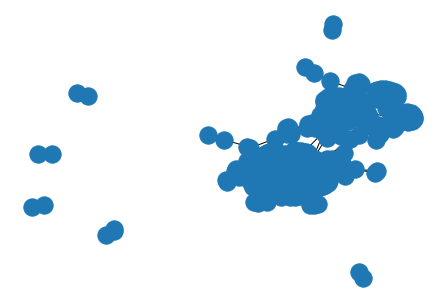

In [4]:
resign_graph = nx.from_pandas_edgelist(nodes_df, source = 'from_user_screen_name', target = 'to_user_screen_name')
nx.draw(resign_graph)

## Fitting Node2Vec

In [5]:
node2vec = Node2Vec(resign_graph, dimensions = 64, walk_length = 10, num_walks = 200, workers = 4)

Computing transition probabilities: 100%|██████████| 362/362 [00:00<00:00, 3989.11it/s]


In [6]:
model = node2vec.fit(window = 10, min_count = 1, batch_words = 4)

#### Evaluating Node2Vec learned 'correctly'

In [7]:
model.wv.most_similar('Bayon_51')

[('gatoyaLvaje', 0.5599783062934875),
 ('consuleduc', 0.5356523394584656),
 ('VasoDeAnibal', 0.5344299674034119),
 ('fortaleza', 0.5269232392311096),
 ('NoticentroWAPA', 0.5204709768295288),
 ('AlexandraLugaro', 0.4904705584049225),
 ('HablaGuillo', 0.44558191299438477),
 ('gvbo15', 0.40004467964172363),
 ('Anniesmell_Bori', 0.39366447925567627),
 ('cuchy68', 0.38614344596862793)]

### Extracting embeddings

In [8]:
vocabulary = list(model.wv.vocab.keys())

embeddings = {}

for user in vocabulary:
    embeddings.update({user: model.wv[user]})

In [9]:
embeddings_df = pd.DataFrame.from_dict(embeddings, orient = 'index')

## Reducing embeddings dimensions

In [10]:
pca = PCA(n_components = 2)
pca.fit(embeddings_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca_components = pd.DataFrame(pca.transform(embeddings_df))
pca_components.index = embeddings_df.index

In [12]:
users_botscore = {}

for user in vocabulary:
    botscore =  resign_df.query(f"from_user_screen_name == '{user}'").from_user_botscore.unique()
    users_botscore.update({user: botscore})
    
for user in vocabulary:
    if users_botscore[user].size == 0:
        botscore =  resign_df.query(f"to_user_screen_name == '{user}'").to_user_botscore.unique()
        users_botscore.update({user: botscore})

In [13]:
users_info = pd.DataFrame.from_dict(users_botscore, orient='index', columns=['botscore'])
user_pca = pd.concat([pca_components, users_info], axis = 1)

## Visualizing Node Embeddings

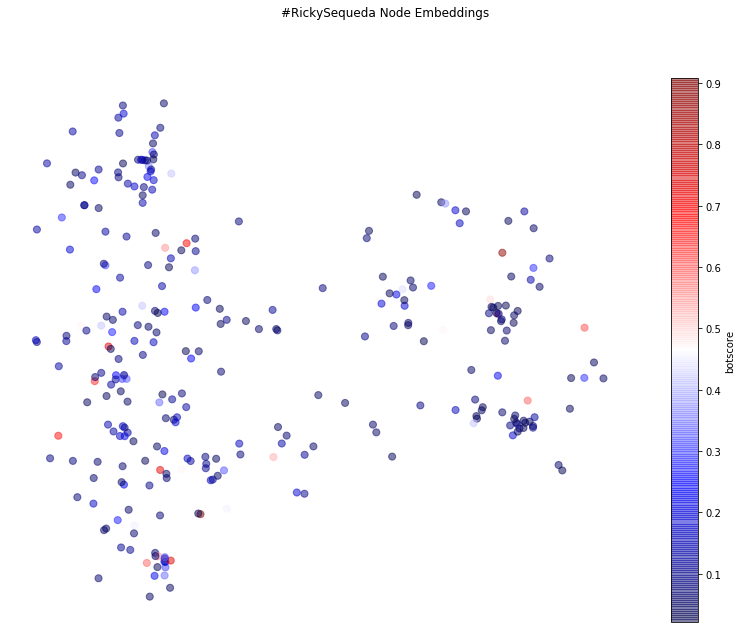

In [15]:
user_pca.plot(x = 0, y = 1, kind = 'scatter', c = 'botscore', 
              s = 50, figsize = (14, 10), cmap = cm.seismic, 
              alpha = 0.5)

plt.axis('off')
plt.suptitle('#RickySequeda Node Embeddings')
plt.savefig('imgs/sequeda_embeddings.png')

## K Means Clustering

In [17]:
from sklearn.cluster import KMeans

In [37]:
k = range(2, 30)
inertia = []

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=2019)
    kmeans.fit(embeddings_df)
    inertia.append(kmeans.inertia_)

### Looking at the inertia of the method with each k

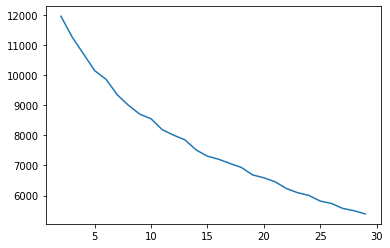

In [38]:
plt.plot(k, inertia);

## Using Gaussian Mixture Models to compare with K Means

In [39]:
from sklearn import mixture

In [40]:
aic = []
bic = []

for i in k:
    gmm = mixture.GaussianMixture(n_components = i, random_state=2019)
    gmm.fit(embeddings_df)
    aic.append(gmm.aic(embeddings_df))
    bic.append(gmm.bic(embeddings_df))

#### Looking at AIC

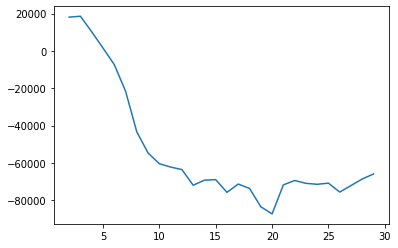

In [41]:
plt.plot(k, aic);

#### Looking at BIC

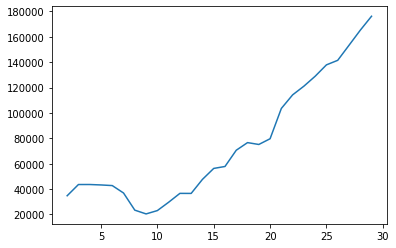

In [42]:
plt.plot(k, bic);

In [47]:
kmeans = KMeans(n_clusters=10, random_state=2019)
kmeans.fit(embeddings_df);

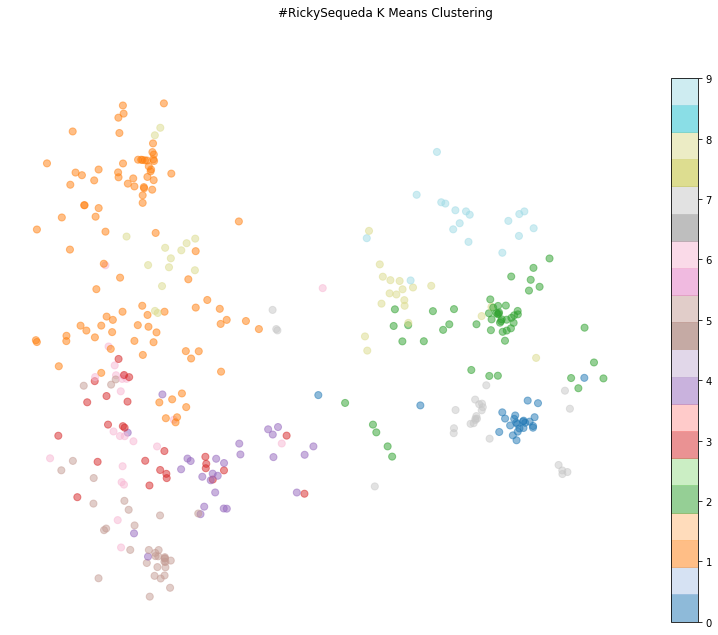

In [50]:
user_pca.plot(x = 0, y = 1, kind = 'scatter', c = kmeans.labels_, 
              s = 50, figsize = (14, 10), cmap = cm.tab20, 
              alpha = 0.5)

plt.axis('off')
plt.suptitle('#RickySequeda K Means Clustering')
plt.savefig('imgs/sequeda_kmeans_clustering.png')